# Permanent Magnet Synchrone Motor


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline

from sklearn.preprocessing import Imputer
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score,mean_squared_error


from sklearn import svm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
#seaborn
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor



from sklearn import neighbors
from math import sqrt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# Any results you write to the current directory are saved as output.

data/pmsm_temperature_data.csv


## read data


In [2]:

#df = pd.read_csv('data/pmsm_temperature_data.csv', 
#                 usecols=[0,1,2,3,4,5,6,7,8,9,10,11])

df = pd.read_csv('data/pmsm_temperature_data.csv')
#df = pd.read_csv('../input/pmsm_temperature_data.csv', 
 #                usecols=[0,1,2,3,4,5,6,7,8,9,10,11])
df.head(10)

ambient   coolant       u_d       u_q  motor_speed    torque       i_d  \
0 -0.752143 -1.118446  0.327935 -1.297858    -1.222428 -0.250182  1.029572   
1 -0.771263 -1.117021  0.329665 -1.297686    -1.222429 -0.249133  1.029509   
2 -0.782892 -1.116681  0.332771 -1.301822    -1.222428 -0.249431  1.029448   
3 -0.780935 -1.116764  0.333700 -1.301852    -1.222430 -0.248636  1.032845   
4 -0.774043 -1.116775  0.335206 -1.303118    -1.222429 -0.248701  1.031807   
5 -0.762936 -1.116955  0.334901 -1.303017    -1.222429 -0.248197  1.031031   
6 -0.749228 -1.116170  0.335014 -1.302082    -1.222430 -0.247914  1.030493   
7 -0.738450 -1.113986  0.336256 -1.305155    -1.222432 -0.248321  1.030107   
8 -0.730910 -1.111828  0.334905 -1.303790    -1.222432 -0.247785  1.029851   
9 -0.727130 -1.109486  0.335988 -1.305633    -1.222431 -0.248294  1.029636   

        i_q        pm  stator_yoke  stator_tooth  stator_winding  profile_id  
0 -0.245860 -2.522071    -1.831422     -2.066143       -2.018033           4  
1 -0.245832 -2.522418    -1.830969     -2.064859       -2.017631           4  
2 -0.245818 -2.522673    -1.830400     -2.064073       -2.017343           4  
3 -0.246955 -2.521639    -1.830333     -2.063137       -2.017632           4  
4 -0.246610 -2.521900    -1.830498     -2.062795       -2.018145           4  
5 -0.246341 -2.522203    -1.831931     -2.062549       -2.017884           4  
6 -0.246162 -2.522538    -1.833012     -2.062115       -2.017243           4  
7 -0.246035 -2.522844    -1.832182     -2.061953       -2.017213           4  
8 -0.245981 -2.522808    -1.831576     -2.062443       -2.017739           4  
9 -0.245888 -2.522677    -1.831438     -2.062317       -2.018180           4

## data description


In [4]:
df.info()


&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


In [101]:
df.describe().T


count       mean        std       min        25%  \
ambient         998070.0  -0.003905   0.993127 -8.573954  -0.599385   
coolant         998070.0   0.004723   1.002423 -1.429349  -1.037925   
u_d             998070.0   0.004780   0.997878 -1.655373  -0.826359   
u_q             998070.0  -0.005690   1.002330 -1.861463  -0.927390   
motor_speed     998070.0  -0.006336   1.001229 -1.371529  -0.951892   
torque          998070.0  -0.003333   0.997907 -3.345953  -0.266917   
i_d             998070.0   0.006043   0.998994 -3.245874  -0.756296   
i_q             998070.0  -0.003194   0.997912 -3.341639  -0.257269   
pm              998070.0  -0.004396   0.995686 -2.631991  -0.672308   
stator_yoke     998070.0   0.000609   1.001049 -1.834688  -0.747265   
stator_tooth    998070.0  -0.002208   0.999597 -2.066143  -0.761951   
stator_winding  998070.0  -0.003935   0.998343 -2.019973  -0.725622   
profile_id      998070.0  50.732001  22.073125  4.000000  32.000000   

                      50%        75%        max  
ambient          0.266157   0.686675   2.967117  
coolant         -0.177187   0.650709   2.649032  
u_d              0.267542   0.358491   2.274734  
u_q             -0.099818   0.852625   1.793498  
motor_speed     -0.140246   0.853584   2.024164  
torque          -0.187246   0.547171   3.016971  
i_d              0.213935   1.013975   1.060937  
i_q             -0.190076   0.499260   2.914185  
pm               0.094367   0.680691   2.917456  
stator_yoke     -0.057226   0.697344   2.449158  
stator_tooth     0.005085   0.772239   2.326668  
stator_winding   0.006536   0.725660   2.653781  
profile_id      56.000000  68.000000  81.000000

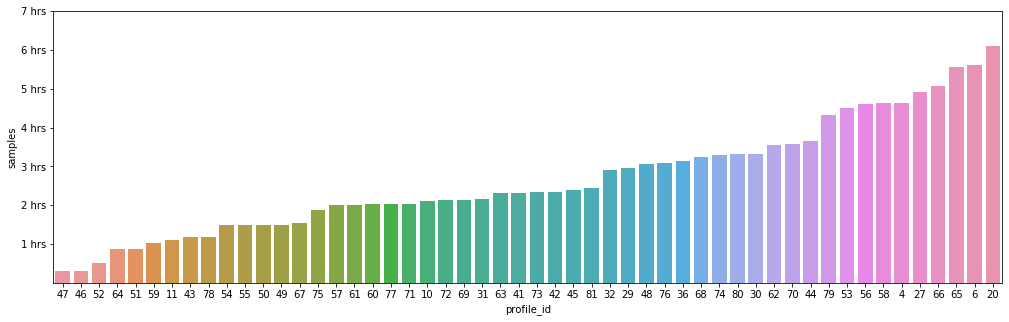

In [3]:
# show 
fig = plt.figure(figsize=(17, 5))
grpd = df.groupby(['profile_id'])
_df = grpd.size().sort_values().rename('samples').reset_index()
ordered_ids = _df.profile_id.values.tolist()
sns.barplot(y='samples', x='profile_id', data=_df, order=ordered_ids)
tcks = plt.yticks(2*3600*np.arange(1, 8), [f'{a} hrs' for a in range(1, 8)]) # 2Hz sample rate

In [5]:
df.isnull().values.any()


False

In [6]:
nans=pd.isnull(df).sum()
nans[nans>0]

Series([], dtype: int64)

In [7]:
df.dtypes.value_counts()

float64    12
int64       1
dtype: int64

In [8]:
df.corr()

ambient   coolant       u_d       u_q  motor_speed    torque  \
ambient         1.000000  0.434435  0.194754  0.087430     0.078283 -0.262264   
coolant         0.434435  1.000000  0.178708  0.027851    -0.033332 -0.189617   
u_d             0.194754  0.178708  1.000000 -0.027472    -0.233828 -0.821325   
u_q             0.087430  0.027851 -0.027472  1.000000     0.716897 -0.037262   
motor_speed     0.078283 -0.033332 -0.233828  0.716897     1.000000  0.024517   
torque         -0.262264 -0.189617 -0.821325 -0.037262     0.024517  1.000000   
i_d             0.005605  0.108489  0.358517 -0.181855    -0.722914 -0.239059   
i_q            -0.260562 -0.186060 -0.796586 -0.026348     0.006323  0.996560   
pm              0.501496  0.430548 -0.082564  0.101236     0.332419 -0.072905   
stator_yoke     0.451616  0.874037  0.041428  0.106186     0.182564 -0.092207   
stator_tooth    0.396742  0.689003 -0.066256  0.149017     0.333909 -0.011055   
stator_winding  0.301883  0.509298 -0.150714  0.125445     0.393154  0.080981   
profile_id      0.384565  0.499669  0.300771 -0.122260    -0.166225 -0.257446   

                     i_d       i_q        pm  stator_yoke  stator_tooth  \
ambient         0.005605 -0.260562  0.501496     0.451616      0.396742   
coolant         0.108489 -0.186060  0.430548     0.874037      0.689003   
u_d             0.358517 -0.796586 -0.082564     0.041428     -0.066256   
u_q            -0.181855 -0.026348  0.101236     0.106186      0.149017   
motor_speed    -0.722914  0.006323  0.332419     0.182564      0.333909   
torque         -0.239059  0.996560 -0.072905    -0.092207     -0.011055   
i_d             1.000000 -0.204230 -0.299227    -0.179903     -0.387712   
i_q            -0.204230  1.000000 -0.086486    -0.098753     -0.025191   
pm             -0.299227 -0.086486  1.000000     0.695014      0.768352   
stator_yoke    -0.179903 -0.098753  0.695014     1.000000      0.949898   
stator_tooth   -0.387712 -0.025191  0.768352     0.949898      1.000000   
stator_winding -0.539924  0.060949  0.729561     0.845144      0.965633   
profile_id      0.142368 -0.256127  0.156735     0.398021      0.280994   

                stator_winding  profile_id  
ambient               0.301883    0.384565  
coolant               0.509298    0.499669  
u_d                  -0.150714    0.300771  
u_q                   0.125445   -0.122260  
motor_speed           0.393154   -0.166225  
torque                0.080981   -0.257446  
i_d                  -0.539924    0.142368  
i_q                   0.060949   -0.256127  
pm                    0.729561    0.156735  
stator_yoke           0.845144    0.398021  
stator_tooth          0.965633    0.280994  
stator_winding        1.000000    0.181908  
profile_id            0.181908    1.000000

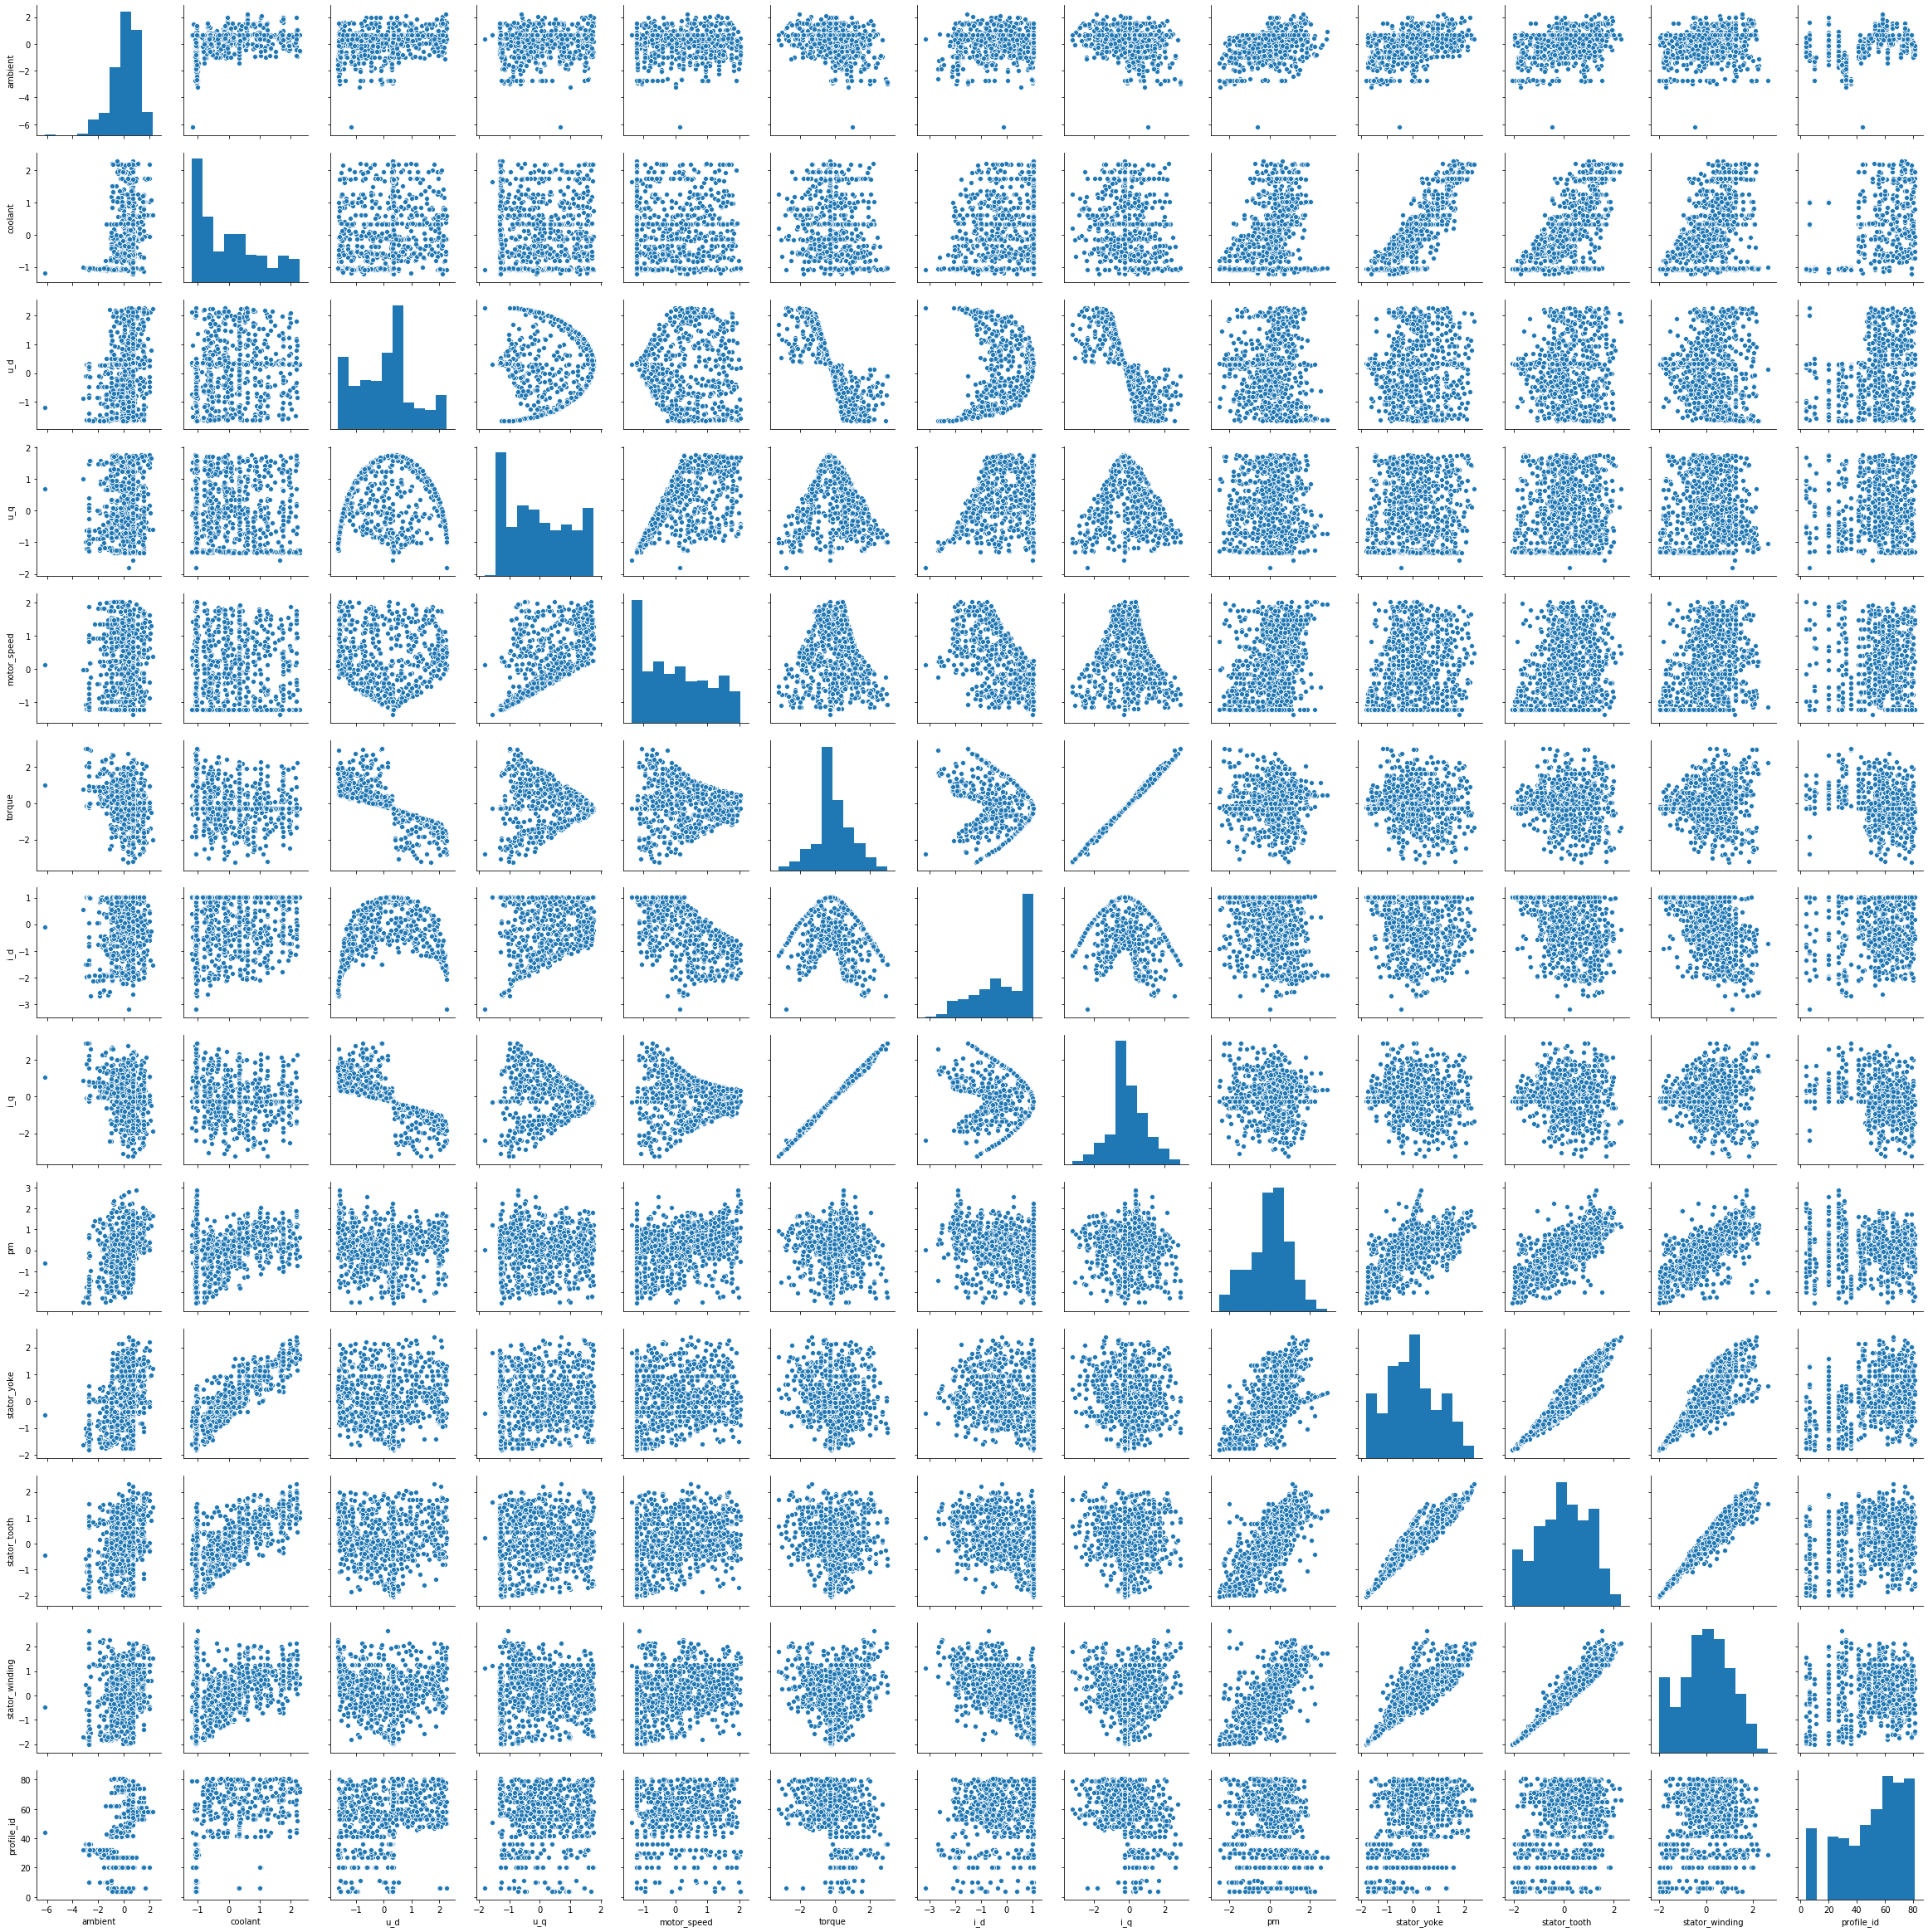

In [10]:
#sns.jointplot(x='i_d', y='motor_speed', data=df,  kind='reg')
#sns.pairplot(df.sample(1000))
sns.pairplot(df.sample(frac=0.001))

plt.show()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7fa62bc06790&gt;

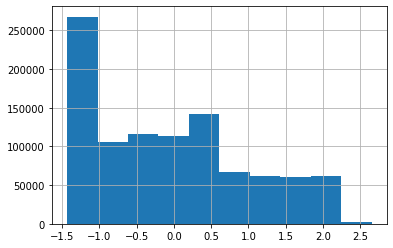

In [3]:
df['coolant'].hist()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f858af73250&gt;

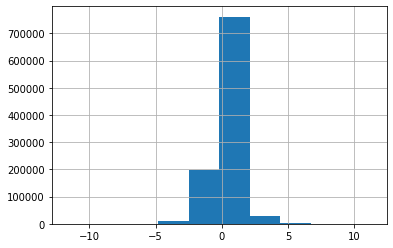

In [3]:
# coolant
df2 = df.copy()

coolant = df2['coolant']
logCoolant = np.sign(coolant)*np.log(abs(coolant))

# new coolant scaled : log transformation from coolant
logCoolant.hist( )


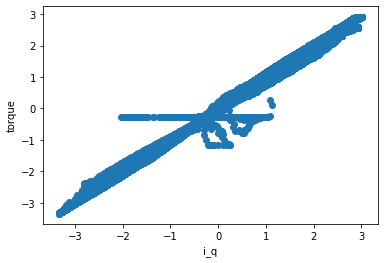

In [5]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(df2['torque'],df2['i_q'])
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("i_q")
plt.ylabel("torque")
plt.show()

&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f858b31f990&gt;

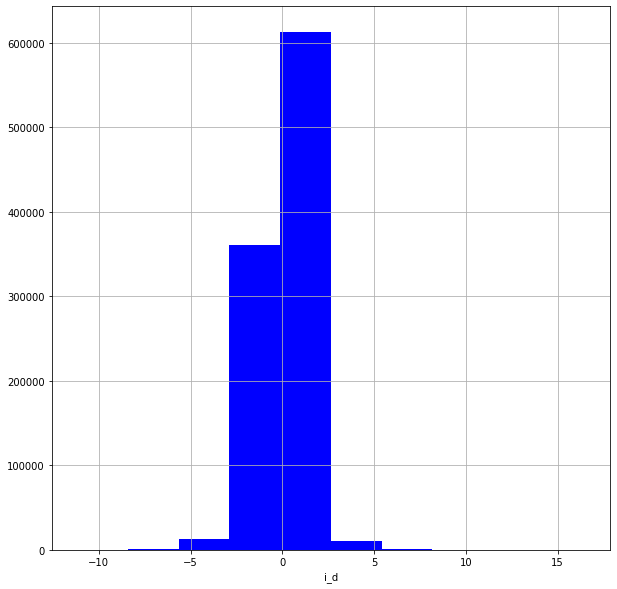

In [4]:

I_d = df2['i_d']
logI_d = np.sign(I_d)*np.log(abs(I_d))

# new coolant scaled : log transformation from coolant
f,ax=plt.subplots(figsize=(10,10))
I_d.hist(ax=ax, color="b")
ax.set_xlabel('i_d')
#ax.set_title('histogramme i_d')
logI_d.hist(ax=ax ,color="b")


&lt;matplotlib.axes._subplots.AxesSubplot at 0x7f858bc138d0&gt;

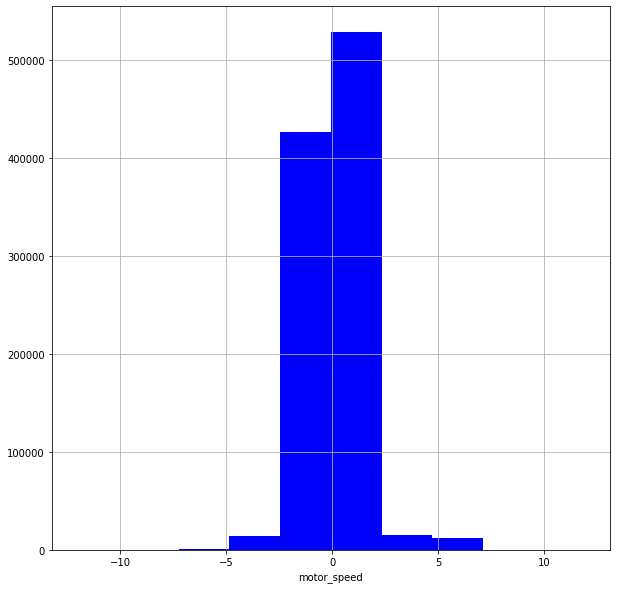

In [6]:

motor_speed = df2['motor_speed']
logmotor_speed = np.sign(motor_speed)*np.log(abs(motor_speed))

# new coolant scaled : log transformation from coolant
f,ax=plt.subplots(figsize=(10,10))
motor_speed.hist(ax=ax, color="b")
ax.set_xlabel('motor_speed')
#ax.set_title('histogramme i_d')
logmotor_speed.hist(color="b")

In [8]:
# scale and normalization
# log normalization 
# coolant is long right tail 
#df['newCoolantlog'] = df.coolant.map(np.log)
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
df2afterTransformation = df2.drop(['coolant', 'i_d', 'motor_speed'], axis =1)
df2afterTransformation['logCoolant'] = logCoolant
df2afterTransformation['logI_d'] = logI_d
df2afterTransformation['logMotor_speed'] = logmotor_speed
ss.fit(df2afterTransformation)
from pandas import DataFrame

df2afterTransformationScale = DataFrame(ss.transform(df2afterTransformation, copy=True), columns=df2afterTransformation.columns)




In [9]:
df2afterTransformationScale.describe().T


count          mean       std        min       25%  \
ambient         998070.0 -8.710865e-14  1.000001  -8.629364 -0.599601   
u_d             998070.0 -5.432324e-15  1.000001  -1.663685 -0.832907   
u_q             998070.0  3.209995e-16  1.000001  -1.851460 -0.919558   
torque          998070.0 -5.696427e-13  1.000001  -3.349634 -0.264138   
i_q             998070.0  9.691522e-16  1.000001  -3.345431 -0.254607   
pm              998070.0 -1.484235e-15  1.000001  -2.638981 -0.670806   
stator_yoke     998070.0 -1.530093e-14  1.000001  -1.833374 -0.747091   
stator_tooth    998070.0  1.157004e-15  1.000001  -2.064767 -0.760049   
stator_winding  998070.0 -6.732676e-15  1.000001  -2.019386 -0.722885   
profile_id      998070.0 -9.930510e-13  1.000001  -2.117146 -0.848634   
logCoolant      998070.0  4.226449e-15  1.000001 -12.062947 -0.208480   
logI_d          998070.0  2.197153e-15  1.000001 -11.584964 -0.370306   
logMotor_speed  998070.0 -5.532915e-15  1.000001 -10.703135 -0.290281   

                     50%       75%        max  
ambient         0.271932  0.695360   2.991585  
u_d             0.263321  0.354463   2.274782  
u_q            -0.093909  0.856320   1.795006  
torque         -0.184299  0.551659   3.026641  
i_q            -0.187273  0.503506   2.923484  
pm              0.099191  0.688056   2.934512  
stator_yoke    -0.057774  0.696005   2.445984  
stator_tooth    0.007296  0.774759   2.329815  
stator_winding  0.010489  0.730807   2.662129  
profile_id      0.238661  0.782309   1.371261  
logCoolant     -0.143405  0.430950  11.430807  
logI_d          0.074960  0.121353  17.215473  
logMotor_speed -0.070246  0.307821  10.357088

&lt;seaborn.axisgrid.PairGrid at 0x7fe8c63335d0&gt;

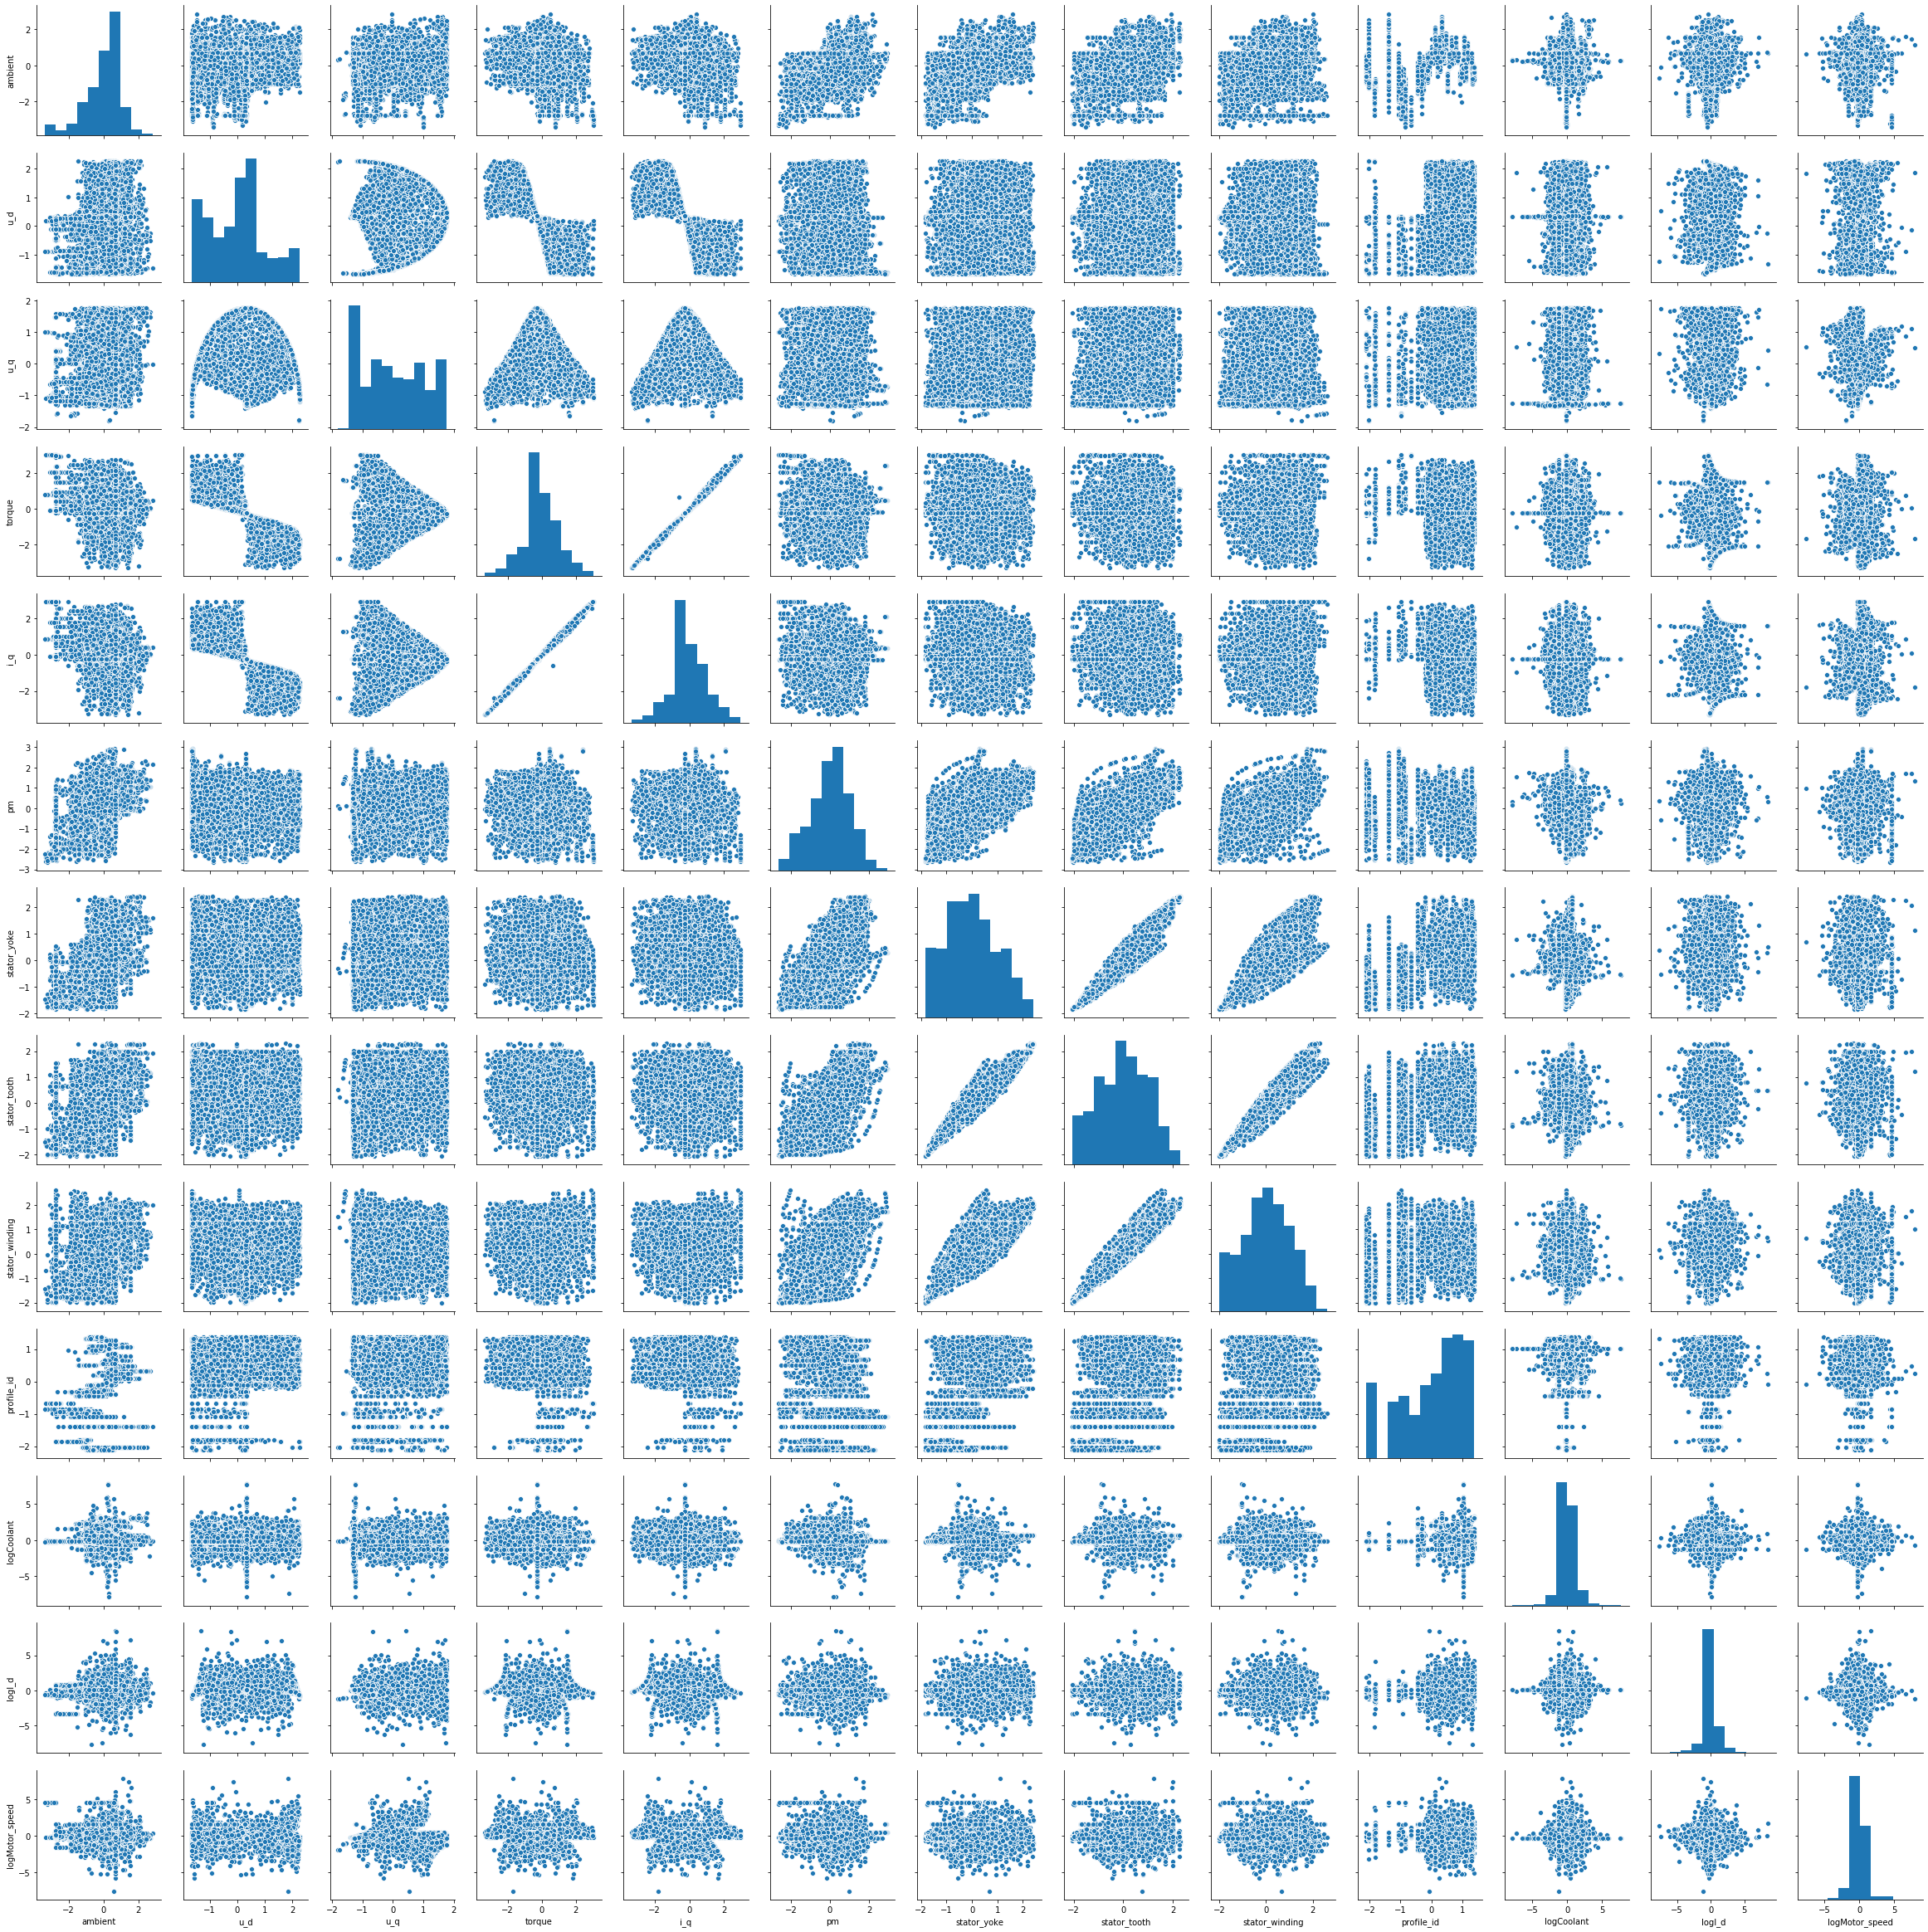

In [16]:
# plot scaled

sns.pairplot(df2afterTransformationScale.sample(frac=0.0001))





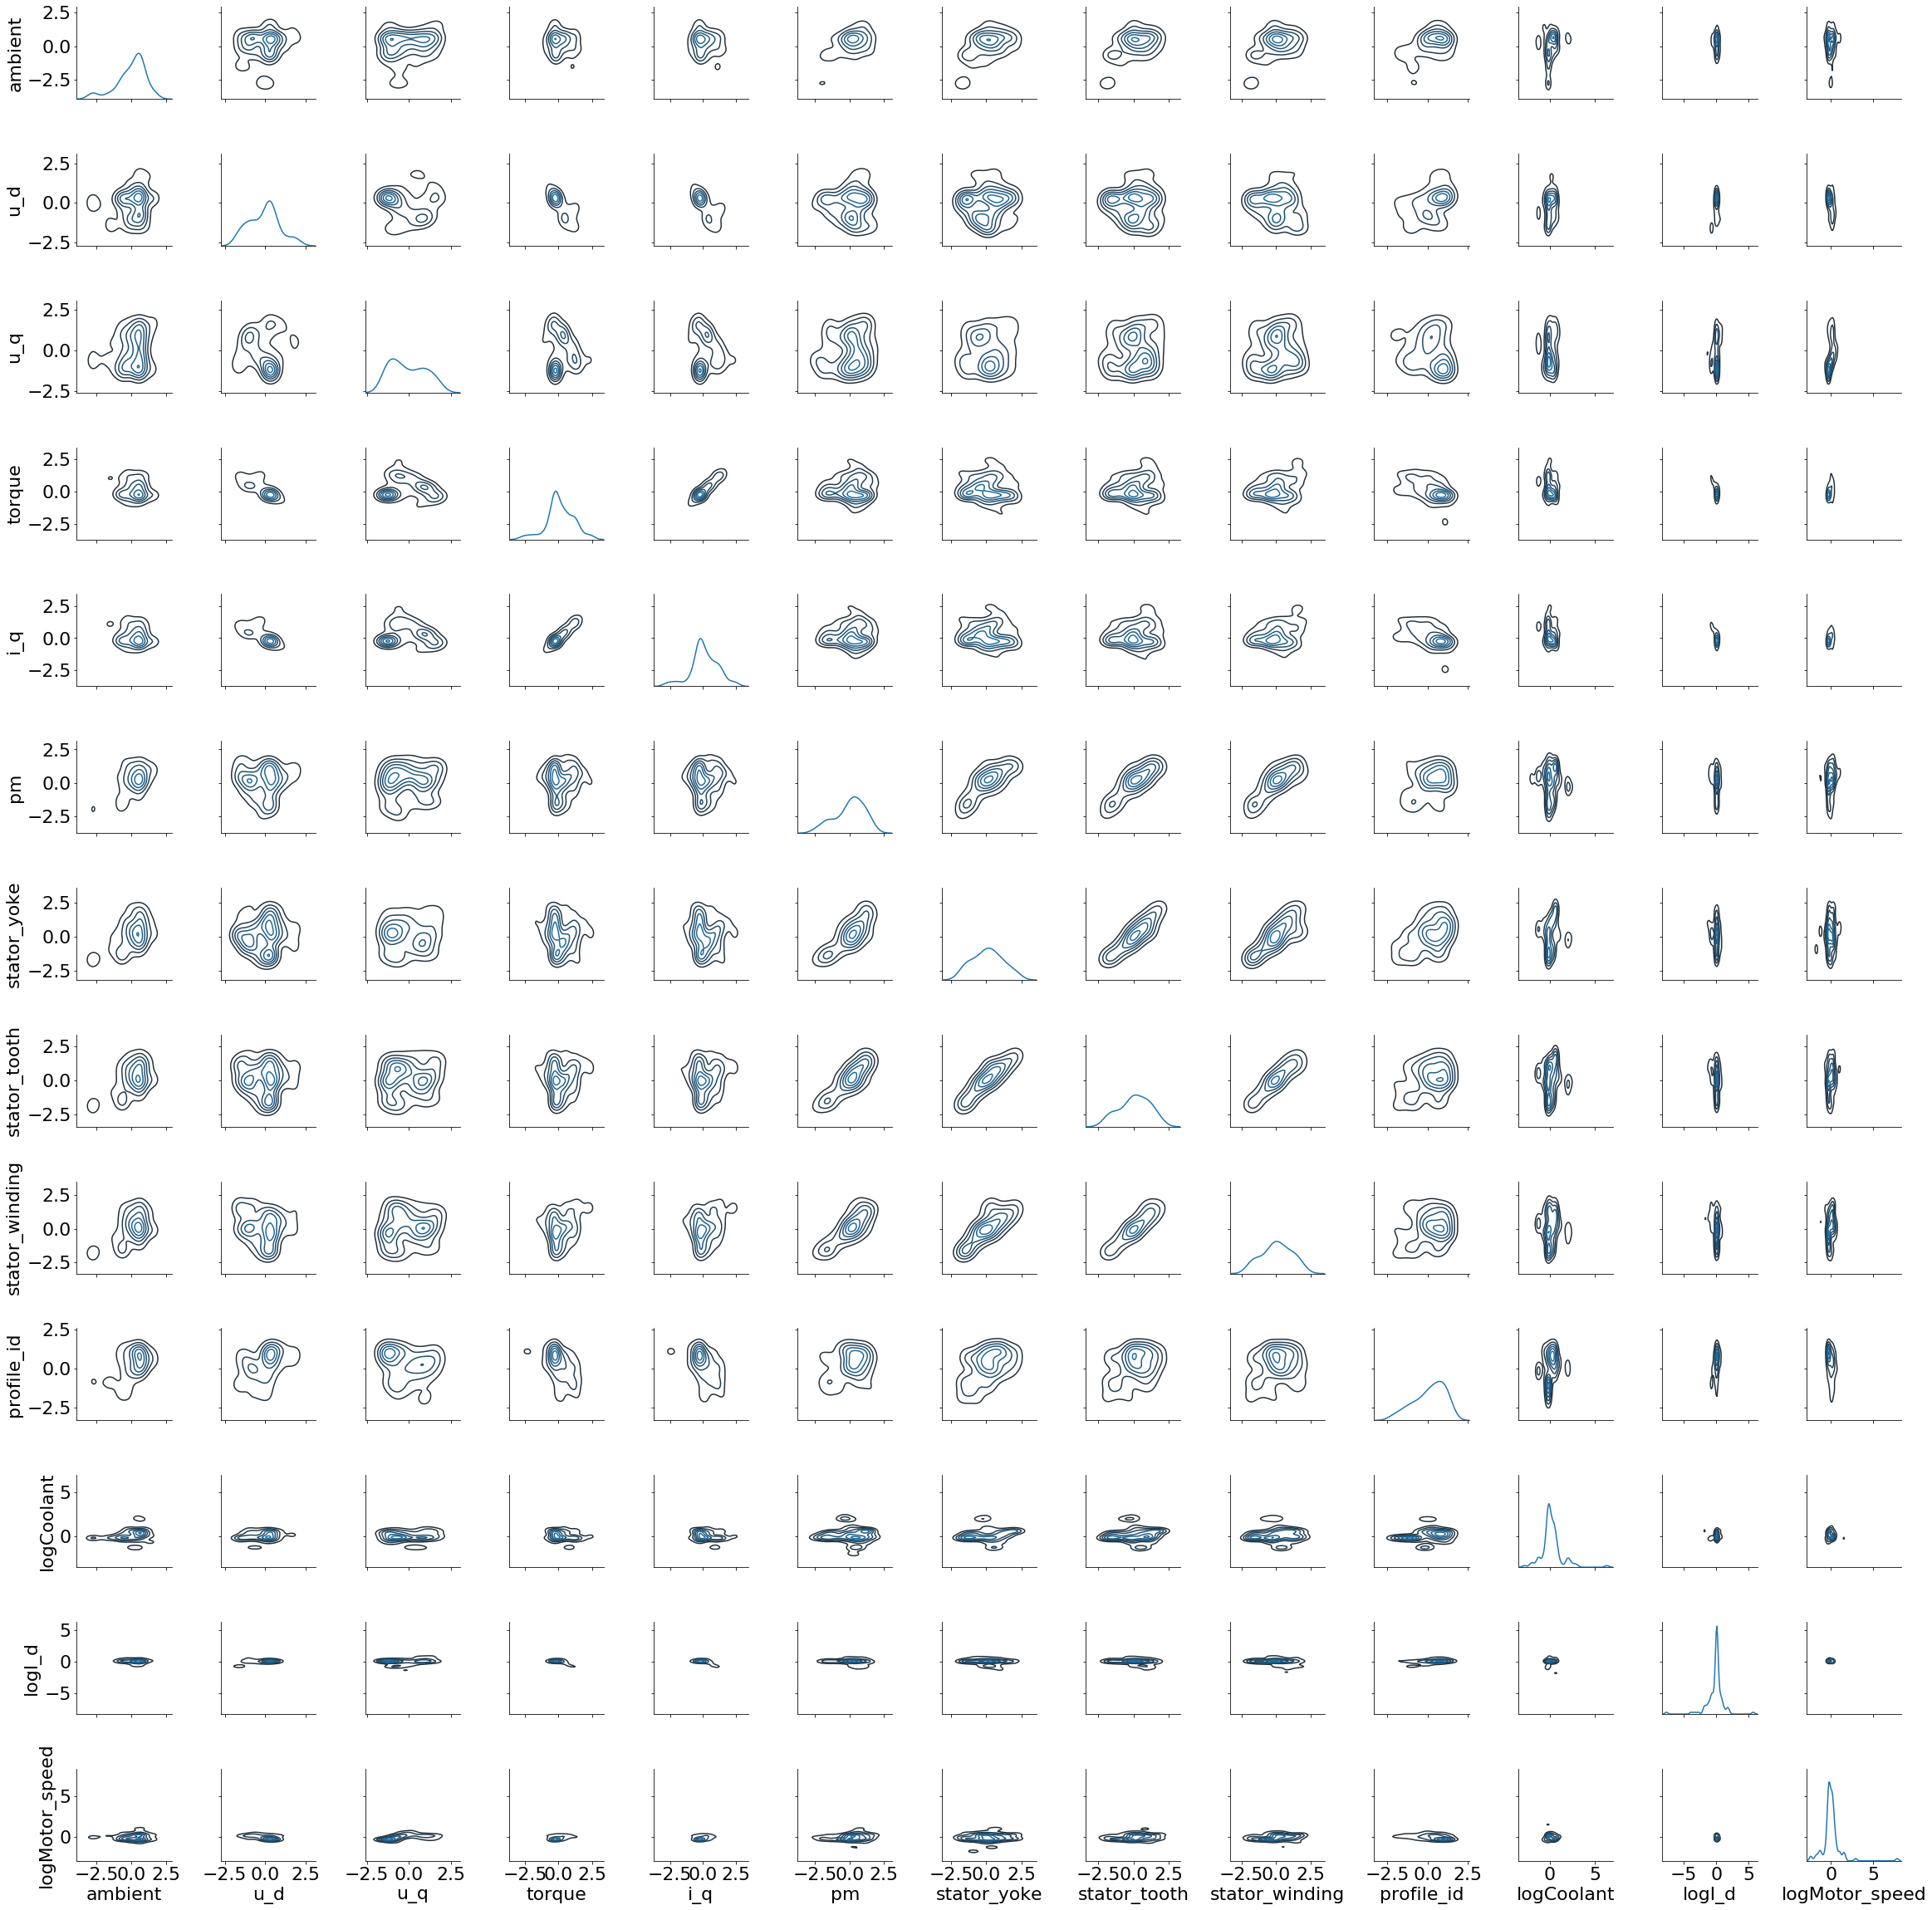

In [10]:
#reduced_df = df.drop(['stator_yoke', 'stator_tooth', 'stator_winding'], axis=1)
matplotlib.rcParams.update({'font.size': 22})
g = sns.PairGrid(df2afterTransformationScale.sample(frac=0.0001))
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);

## correlation map

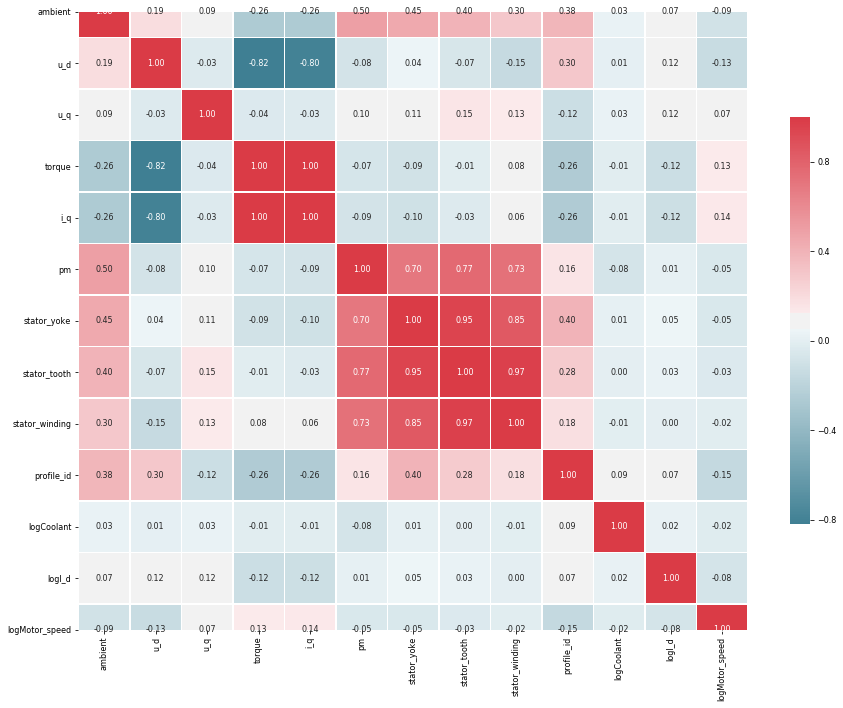

In [12]:
#correlation map
f,ax=plt.subplots(figsize=(15,15))
matplotlib.rcParams.update({'font.size': 8})

corr=df2afterTransformationScale.corr()

sns.heatmap(corr, annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5},
            mask= np.zeros_like(corr,dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax)



plt.show()

In [ ]:
# il faut ajouter une feature executionTime per profile
## pas necessaire car l'état de demarrage est aléatoire (le moteur peut ne pas commencer à froid lors d'une session)

In [13]:
# after scaling
X=df2afterTransformationScale.drop(['profile_id',"pm" , "torque", 'stator_tooth','stator_yoke', 'stator_winding'], axis=1)
y=df2afterTransformationScale["pm"]

# whithout scaling
X2=df2afterTransformation.drop(['profile_id',"pm" , "torque", 'stator_tooth','stator_yoke', 'stator_winding'], axis=1)
y2=df2afterTransformation["pm"]




from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)
X2_train,X2_test,y2_train,y2_test=train_test_split(X2,y2,test_size=0.2, random_state=42)



# lasso

In [35]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774

dfLasso = df.copy()

X=dfLasso.drop(['profile_id', "pm" ,"torque", "stator_tooth",'stator_yoke', 'stator_winding' 
                #,'i_d', 'coolant', 'motor_speed'
                    ],
               axis=1)
y=dfLasso["pm"]


#X['logCoolant'] = logCoolant
#X['logI_d'] = logI_d
#X['logmotor_speed'] = logmotor_speed


from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [36]:
#régression Lasso, paramètres par défaut (alpha = 1.0)
from sklearn.linear_model import Lasso, LassoCV
lasso = Lasso(fit_intercept=False,normalize=False)
print(lasso)
Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
 normalize=False, positive=False, precompute=False, random_state=None,
 selection='cyclic', tol=0.0001, warm_start=False)
#apprentissage
lasso.fit(X_train_transformed,y_train_transformed)
print(lasso.coef_)

Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection=&#39;cyclic&#39;, tol=0.0001, warm_start=False)
[ 0.  0. -0.  0.  0. -0. -0.]


In [26]:
# compute alphas for lasso
my_alphas = np.array([0.0001,0.001,0.002,0.003,0.004,0.007,0.009,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6])
#obtention des valeurs des coefs. corresp.
from sklearn.linear_model import lasso_path
alpha_for_path, coefs_lasso, _ = lasso_path(X_train,y_train,alphas=my_alphas)
print(coefs_lasso.shape) 

(7, 15)


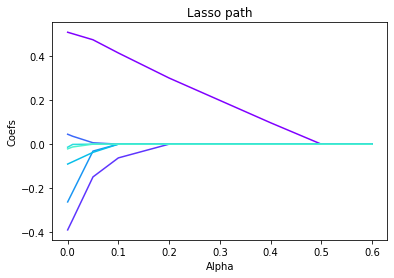

In [37]:
#lass path
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0,1,16))
#graphique lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]):
 plt.plot(alpha_for_path,coefs_lasso[i,:],c=colors[i])

plt.xlabel('Alpha')
plt.ylabel('Coefs')
plt.title('Lasso path')
plt.show()

     alpha  Nb non-zero coefs
0   0.6000                  0
1   0.5000                  0
2   0.4000                  1
3   0.3000                  1
4   0.2000                  1
5   0.1000                  2
6   0.0500                  5
7   0.0100                  7
8   0.0090                  7
9   0.0070                  7
10  0.0040                  7
11  0.0030                  7
12  0.0020                  7
13  0.0010                  7
14  0.0001                  7


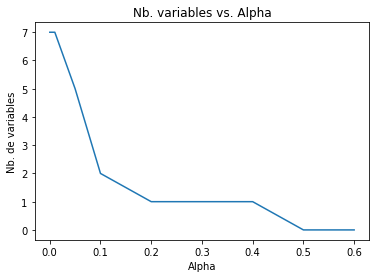

     Variables  Coefficients
0      ambient      0.502610
1      coolant     -0.355903
2          u_d      0.038561
3          u_q     -0.230100
4  motor_speed     -0.082918
5          i_d     -0.004965
6          i_q     -0.015291


In [38]:
#nombre de coefs. non-nuls pour chaque alpha
import pandas
nbNonZero = np.apply_along_axis(func1d=np.count_nonzero,arr=coefs_lasso,axis=0)
print(pandas.DataFrame({'alpha':alpha_for_path,'Nb non-zero coefs':nbNonZero}))

plt.plot(alpha_for_path,nbNonZero)
plt.xlabel('Alpha')
plt.ylabel('Nb. de variables')
plt.title('Nb. variables vs. Alpha')
plt.show()

#nom des variables
nom_var = X_train.columns
#coefficients pour alpha=0.007 (colonne n°9)
coefsForAlpha = coefs_lasso[:,9]
#affichage des coefficients pour alpha = 0.007
print(pandas.DataFrame({'Variables':nom_var,'Coefficients':coefsForAlpha}))

In [39]:
#outil pour la détection de la solution la plus performante en validation croisée
#random_state = 0 pour fixer l’initialisation du générateur de nombre aléatoire
#cv = 5 pour 5-fold validation croisée
lcv = LassoCV(alphas=my_alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)

#lancement sur l'échantillon d'apprentissage
lcv.fit(X_train_transformed,y_train_transformed) 
print(lcv.alphas_) 
#valeurs des MSE en validation croisée
print(lcv.mse_path_)




[6.e-01 5.e-01 4.e-01 3.e-01 2.e-01 1.e-01 5.e-02 1.e-02 9.e-03 7.e-03
 4.e-03 3.e-03 2.e-03 1.e-03 1.e-04]
[[0.99447583 0.99722149 0.99793281 1.00509859 1.00527132]
 [0.99152325 0.99602238 0.99570465 1.00429528 1.00527132]
 [0.90325327 0.90586037 0.90666245 0.91379378 0.91389255]
 [0.8019773  0.80303986 0.80483037 0.81102955 0.80976328]
 [0.67534036 0.67519473 0.67758522 0.68123608 0.67920029]
 [0.59691514 0.59531601 0.59808707 0.59992089 0.59787355]
 [0.56218084 0.56023172 0.56364904 0.56359863 0.56213645]
 [0.53375831 0.52920933 0.53272676 0.53148782 0.53077069]
 [0.53354038 0.5289295  0.53245359 0.53119124 0.53049745]
 [0.53318253 0.52844965 0.53198814 0.53067793 0.53003043]
 [0.53285728 0.52794446 0.53150294 0.53012202 0.5295442 ]
 [0.53275819 0.52778978 0.53136276 0.52995207 0.52942808]
 [0.53260321 0.52756893 0.53112859 0.52970894 0.52915116]
 [0.53253718 0.52743766 0.53098285 0.5295563  0.52896166]
 [0.53255498 0.52739747 0.53092871 0.52949757 0.52886946]]


     alpha       MSE
0   0.6000  1.000000
1   0.5000  0.998563
2   0.4000  0.908692
3   0.3000  0.806128
4   0.2000  0.677711
5   0.1000  0.597623
6   0.0500  0.562359
7   0.0100  0.531591
8   0.0090  0.531322
9   0.0070  0.530866
10  0.0040  0.530394
11  0.0030  0.530258
12  0.0020  0.530032
13  0.0010  0.529895
14  0.0001  0.529850


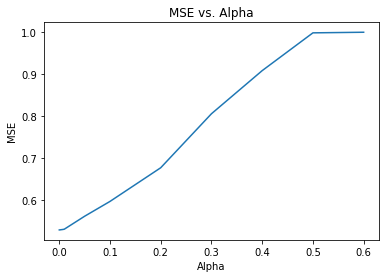

best alpha
0.0001


In [40]:
#moyenne mse en validation croisée pour chaque alpha
avg_mse = np.mean(lcv.mse_path_,axis=1)
#alphas vs. MSE en cross-validation
print(pandas.DataFrame({'alpha':lcv.alphas_,'MSE':avg_mse})) 
#sous-forme graphique
plt.plot(lcv.alphas_,avg_mse)
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alpha')
plt.show()

#best alpha
print('best alpha')
print(lcv.alpha_) 

In [41]:
ypredictedtestLasso = lcv.predict(X_test_transformed)
ypLassoinversed = ss.inverse_transform(ypredictedtestLasso)

#LassoRmseTest=np.sqrt(mean_squared_error(y_test,ypLassoinversed))
#LassoRmseTest
# performance de prediction
print('MSE')
mean_squared_error(y_test,ypLassoinversed)

MSE


0.5247845851930647

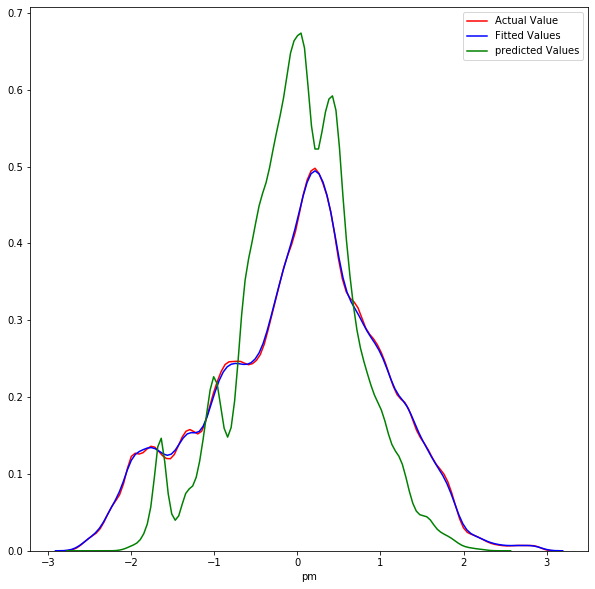

In [42]:
import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(ypLassoinversed, hist=False, color="g", label="predicted Values" , ax=ax1);

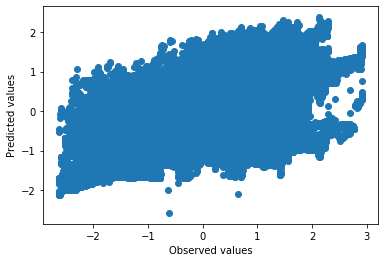

In [43]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,ypLassoinversed)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

OLS

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
#ss = StandardScaler() # -> 0.773837209163774
ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfOLS = df.copy()

X=dfOLS.drop(["pm" ,"torque", "stator_tooth",'profile_id','stator_yoke', 'stator_winding'], axis=1)
y=dfOLS["pm"]

coolant = X['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
X = X.drop(['coolant'], axis =1)
X['newCoolant'] = newCoolant

X.info()
X.columns 

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = pd.DataFrame(ss.fit_transform(X_train), columns= X.columns)
y_train_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_train, columns=['pm'] )), columns=['pm'])
X_test_transformed = pd.DataFrame(ss.fit_transform(X_test) , columns=X.columns)
y_test_transformed = pd.DataFrame(ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] )), columns=['pm'])

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 7 columns):
ambient        998070 non-null float64
u_d            998070 non-null float64
u_q            998070 non-null float64
motor_speed    998070 non-null float64
i_d            998070 non-null float64
i_q            998070 non-null float64
newCoolant     998070 non-null float64
dtypes: float64(7)
memory usage: 53.3 MB


In [14]:
import statsmodels.api as sm
lm=sm.OLS(y_train_transformed, X_train_transformed)

ols=lm.fit()
ols.summary() #All coefficients are significant for the model by looking at the p-value. ( P>|t| )
#print(model.pvalues)



&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          1.402e+06
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        02:59:13   Log-Likelihood:                      4.4315e+05
No. Observations:              798456   AIC:                                 -8.863e+05
Df Residuals:                  798449   BIC:                                 -8.862e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         1.0156      0.002    606.459      0.000       1.012       1.019
u_d            -0.1125      0.001   -110.254      0.000      -0.114      -0.110
u_q            -0.1943      0.001   -174.579      0.000      -0.197      -0.192
motor_speed     0.3024      0.001    210.813      0.000       0.300       0.305
i_d             0.0284      0.001     22.701      0.000       0.026       0.031
i_q            -0.1063      0.001    -73.359      0.000      -0.109      -0.103
newCoolant     -0.4295      0.003   -142.686      0.000      -0.435      -0.424
==============================================================================
Omnibus:                     1451.568   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1800.804
Skew:                          -0.005   Prob(JB):                         0.00
Kurtosis:                       3.232   Cond. No.                         32.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [15]:
import statsmodels.api as sm
lm2=sm.OLS(y_train, X_train)

ols2=lm2.fit()
ols2.summary()#All coefficients are significant for the model by looking at the p-value. ( P>|t| )


&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     pm   R-squared (uncentered):                   0.401
Model:                            OLS   Adj. R-squared (uncentered):              0.401
Method:                 Least Squares   F-statistic:                          7.639e+04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):                        0.00
Time:                        02:59:36   Log-Likelihood:                     -9.2476e+05
No. Observations:              798456   AIC:                                  1.850e+06
Df Residuals:                  798449   BIC:                                  1.850e+06
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P&gt;|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ambient         0.5007      0.001    554.376      0.000       0.499       0.502
u_d            -0.1345      0.002    -81.629      0.000      -0.138      -0.131
u_q            -0.3206      0.002   -170.030      0.000      -0.324      -0.317
motor_speed     0.5408      0.003    193.057      0.000       0.535       0.546
i_d             0.0676      0.002     35.458      0.000       0.064       0.071
i_q            -0.0620      0.002    -37.194      0.000      -0.065      -0.059
newCoolant     -0.0874      0.001    -99.915      0.000      -0.089      -0.086
==============================================================================
Omnibus:                     1557.886   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1948.448
Skew:                          -0.005   Prob(JB):                         0.00
Kurtosis:                       3.242   Cond. No.                         6.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
&quot;&quot;&quot;

In [17]:
# OLS MSE
from sklearn.metrics import r2_score,mean_squared_error

yPredictedTestOls1 = ols.predict(X_test_transformed)
yPredictedTestOls1Inversed = ss.inverse_transform(pd.DataFrame(yPredictedTestOls1 , columns =['pm'] ))

olsRmse=mean_squared_error(y_test,yPredictedTestOls1Inversed)
olsRmse

0.7875362754132154

In [18]:
#OLS2 MSE

yPredictedTestOls2 = ols2.predict(X_test)
ols2Rmse = mean_squared_error(y_test ,yPredictedTestOls2)
ols2Rmse

0.5936519013518646

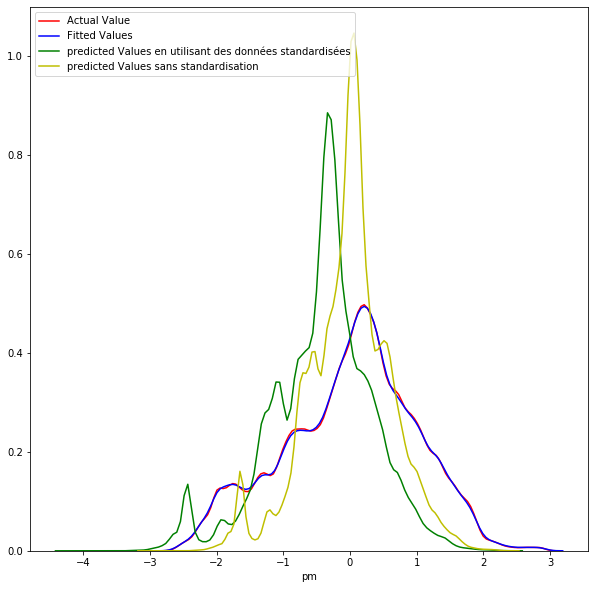

In [23]:
#Visualizing for Multiple Linear Regression y values model1

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(yPredictedTestOls1Inversed, hist=False, color="g", label="predicted Values en utilisant des données standardisées" , ax=ax1);
sns.distplot(yPredictedTestOls2, hist=False, color="y", label="predicted Values sans standardisation" , ax=ax1);



[&lt;matplotlib.lines.Line2D at 0x7fd8a32b6b10&gt;]

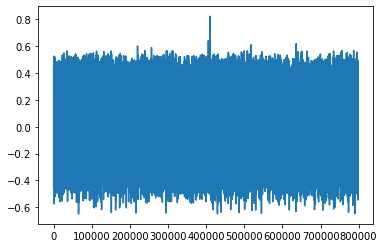

In [20]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols.resid)



[&lt;matplotlib.lines.Line2D at 0x7fd8a3332f90&gt;]

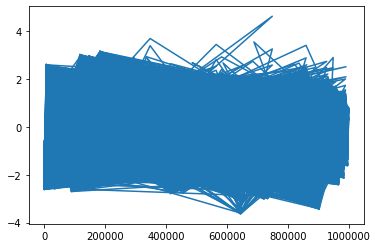

In [21]:
matplotlib.rcParams['agg.path.chunksize'] = 10000
plt.plot(ols2.resid)

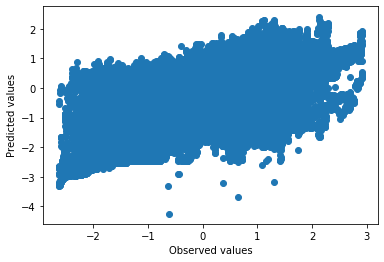

In [24]:
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,yPredictedTestOls1Inversed)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

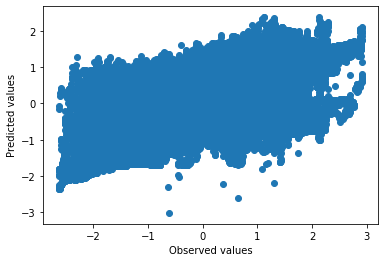

In [25]:
# model sans le scaling
import numpy
#graphique
import matplotlib.pyplot as plt
ax = plt.scatter(y_test,yPredictedTestOls2)
#plt.scatter(y2_test,y2preditTest)
#plt.plot(numpy.arange(0,1.3),numpy.arange(0,1.3))
plt.xlabel("Observed values")
plt.ylabel("Predicted values")
plt.show()

Text(0, 0.5, &#39;predicted vs actual pm&#39;)

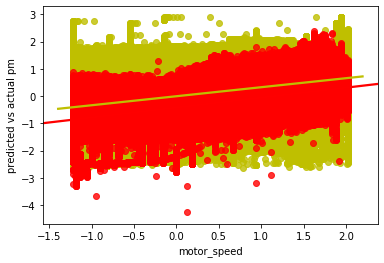

In [28]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=pd.DataFrame(yPredictedTestOls1Inversed, columns=['pm'])["pm"], label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')



Text(0, 0.5, &#39;predicted vs actual pm&#39;)

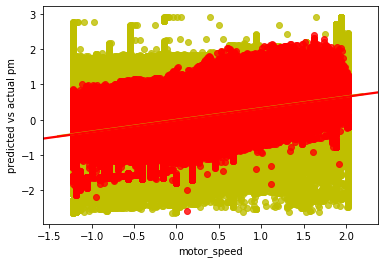

In [40]:
# model withoud scaling
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
ax2 = sns.regplot(x="motor_speed", y=yPredictedTestOls2, label="predicted Value", color="r", data=X_test, ax=ax1);
ax1.set_ylabel('predicted vs actual pm')

In [41]:
 fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(ols, 0, ax=ax)
ax.set_ylabel("pm")

KeyboardInterrupt: 

# KNN

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer, MaxAbsScaler
ss = StandardScaler() # -> 0.773837209163774
#ss = Normalizer() # -> used for NLP TF Idf but what ?
#ss = MinMaxScaler()# -> good 
#ss =    MaxAbsScaler()# ->  0.27318492751506374
# Apply scaler to numeric colu
dfKNN = df.copy()

X=dfKNN.drop(["pm" ,"torque", "stator_tooth",'profile_id','stator_yoke', 'stator_winding'], axis=1)
y=dfKNN["pm"]

coolant = X['coolant']
newCoolant = np.sign(coolant)*np.log(abs(coolant))
df2moisCoolant = X.drop(['coolant'], axis =1)
X['newCoolant'] = newCoolant

from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

X_train_transformed = ss.fit_transform(X_train)
y_train_transformed = ss.fit_transform(pd.DataFrame(y_train, columns =['pm'] ))
X_test_transformed = ss.fit_transform(X_test)
y_test_transformed = ss.fit_transform(pd.DataFrame(y_test, columns =['pm'] ))

In [7]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_transformed, y_train_transformed)  #fit the model
    pred=model.predict(X_test_transformed) #make prediction on test set
    predinversed = ss.inverse_transform(pred)
    error = mean_squared_error(y_test,predinversed) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)


    #####could be done using GridSearchCV 
#from sklearn.model_selection import GridSearchCV
#params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

#knn = neighbors.KNeighborsRegressor()

#model = GridSearchCV(knn, params, cv=5)
#model.fit(x_train,y_train)
#model.best_params_

RMSE value for k=  1 is: 0.04846402696313817
RMSE value for k=  2 is: 0.04259620279782289
RMSE value for k=  3 is: 0.04269149048514235
RMSE value for k=  4 is: 0.04390162511499325
RMSE value for k=  5 is: 0.04569997512328565
RMSE value for k=  6 is: 0.04761405963082875
RMSE value for k=  7 is: 0.04955279907875533
RMSE value for k=  8 is: 0.051536215282021645
RMSE value for k=  9 is: 0.0533743243699961
RMSE value for k=  10 is: 0.05508639616529116


Text(0.5, 0, &#39;k&#39;)

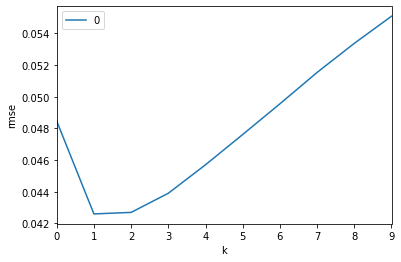

In [8]:
#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val) #elbow curve 
ax =curve.plot()
ax.set_ylabel("rmse")
ax.set_xlabel("k")

In [6]:
rmse_val = [] #to store rmse values for different k
for K in range(10):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = mean_squared_error(y_test,pred) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.03975142431107732
RMSE value for k=  2 is: 0.03557551525743878
RMSE value for k=  3 is: 0.03662748899681886
RMSE value for k=  4 is: 0.03859391908698284
RMSE value for k=  5 is: 0.040872582356193767
RMSE value for k=  6 is: 0.04310477187503101
RMSE value for k=  7 is: 0.04536796254169539
RMSE value for k=  8 is: 0.0476748525634031
RMSE value for k=  9 is: 0.049678318327897944
RMSE value for k=  10 is: 0.051571797359813175


In [9]:
knn_model_rs=KNeighborsRegressor(2).fit(X_train, y_train)
y_pred=knn_model_rs.predict(X_test)
y_pred.shape

(199614,)

In [14]:
knn_model=KNeighborsRegressor(2).fit(X_train_transformed, y_train_transformed)
y2_pred=knn_model.predict(X_test_transformed)
y2_predInversed = ss.inverse_transform(y2_pred)
y2_predInversed.shape

(199614, 1)

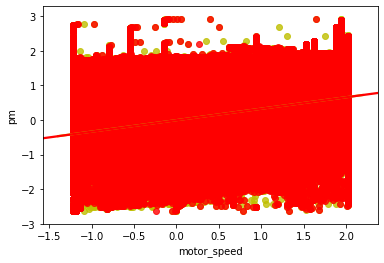

In [12]:
ax1= sns.regplot(x="motor_speed", y=y_test, label="Actual Value", data=X_test, color="y");
sns.regplot(x="motor_speed", y=y_pred, label="predicted Value", color="r", data=X_test, ax=ax1);

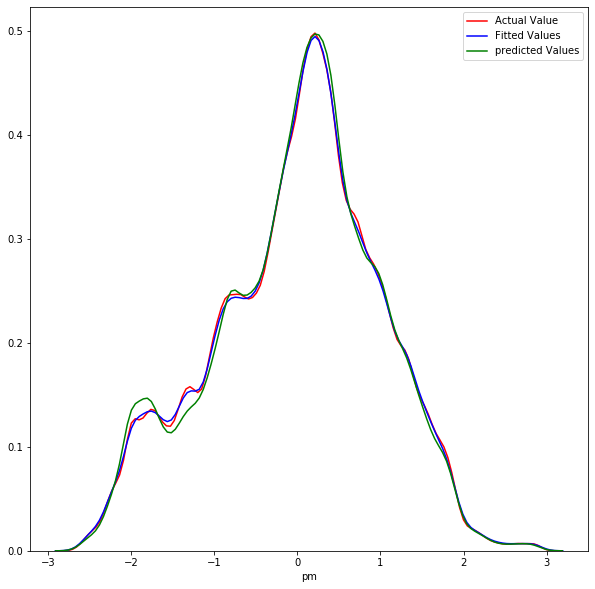

In [15]:

import seaborn as sns
f,ax=plt.subplots(figsize=(10,10))
matplotlib.rcParams.update({'font.size': 10})
ax1 = sns.distplot(y_train, hist=False, color="r", label="Actual Value")
sns.distplot(y_test, hist=False, color="b", label="Fitted Values" , ax=ax1);
sns.distplot(y2_predInversed, hist=False, color="g", label="predicted Values" , ax=ax1);